In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

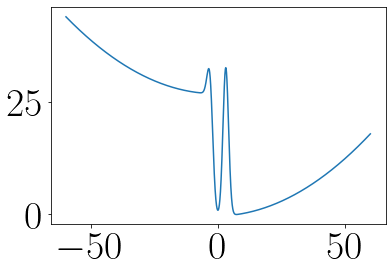

In [26]:
x,y= np.loadtxt("potential_landscape.txt", delimiter = '\t', unpack=True)
plt.plot(x,y)
plt.show()

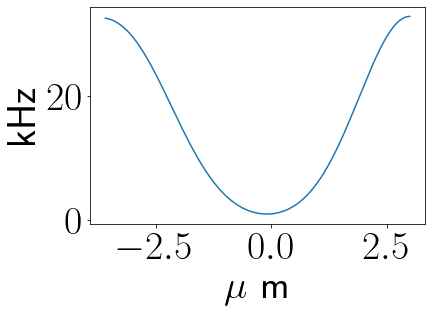

In [27]:
def extract_gate_well_potential(position,potential):
    
    # Position where the gate well starts.
    gate_well_start_index = -3.6
    # Position where the gate well ends.
    gate_well_end_index   = 3.0
    # Extracts the gate well position.
    well_position = position[np.where((position > gate_well_start_index) & (position < gate_well_end_index))]
    # Extract the corresponding potential values for the gate well.
    well_potential = potential[np.where(position == well_position[0])[0][0]:np.where(position == well_position[-1])[0][0]+1]
    
    return [well_position,well_potential]

gate_well_position  = extract_gate_well_potential(x,y)[0]
gate_well_potential = extract_gate_well_potential(x,y)[1]
plt.plot(gate_well_position,gate_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

# Shifting the minimum of $V(x)$ to $x=0$

Minimum of the gate well, =  0.0 , location, =  0.0


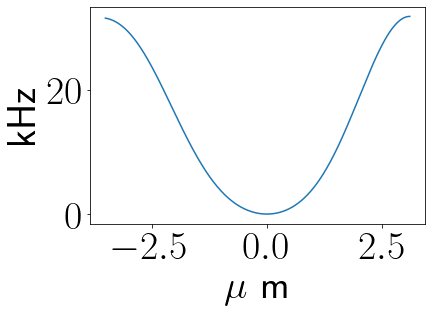

In [28]:
gate_well_potential_min_index = [np.where(gate_well_potential == min(gate_well_potential))][0][0][0]
gate_well_potential = gate_well_potential - min(gate_well_potential)
gate_well_position = gate_well_position-gate_well_position[gate_well_potential_min_index]
# Prints the new location of the potential minima and its value.
print("Minimum of the gate well, = ", min(gate_well_potential), ", location, = ",
      gate_well_position[[np.where(gate_well_potential == min(gate_well_potential))][0][0][0]])
plt.plot(gate_well_position,gate_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

# Extended gate well potential

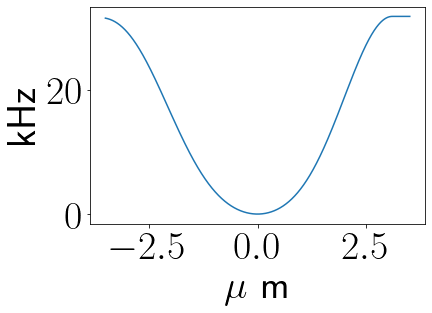

In [29]:
h = (max(gate_well_position)-min(gate_well_position))/len(gate_well_position)
# Creating the extension of the gate well.
gate_well_position_extension = np.arange(max(gate_well_position)+h,np.abs(min(gate_well_position))+h,h)
extended_gate_well_position = np.concatenate((gate_well_position,gate_well_position_extension),axis=0)
extended_gate_well_potential = np.concatenate((gate_well_potential,gate_well_potential[-1]*np.ones(len(gate_well_position_extension))))
plt.plot(extended_gate_well_position,extended_gate_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

pf = open('extended_gate_well.txt','w')
pf = open('extended_gate_well.txt','a')
for i in range(len(extended_gate_well_position)):
    pf.write(str(extended_gate_well_position[i])+'\t'+ str(extended_gate_well_potential[i])+'\n')
pf.close()

# Interpolation of the potential landscape

In [30]:
r"""
def average_nearest_neighbors(x):
    length = len(x) // 2
    new_array = []

    for i in range(0, len(x), 2):
        average = (x[i] + x[i+1]) / 2
        new_array.append(average)

    return new_array

# Finds the next power of two of the length of gate well potential.
next_power = int(2 ** np.ceil(np.log2(len(extended_gate_well_potential))))
N = next_power

def interpolate_array(x, new_length):
    original_length = len(x)
    if original_length >= new_length:
        return x[:new_length]  # Return a slice of the original array if it's already longer or equal to the desired length
    
    # Create a new array with the desired length
    interpolated_x = np.zeros(new_length)

    # Set the endpoints of the interpolated array
    interpolated_x[0] = x[0]
    interpolated_x[-1] = x[-1]

    # Determine the indices for interpolation
    indices = np.linspace(0, original_length - 1, num=new_length, endpoint=True, dtype=int)

    # Interpolate the values between endpoints
    interpolated_x[1:-1] = np.interp(indices[1:-1], range(original_length), x)

    return interpolated_x

def averaged_gate_well(power):
    if power < int(np.ceil(np.log2(len(extended_gate_well_potential)))):
        next_power = int(np.ceil(np.log2(len(extended_gate_well_potential))))
        averaged_gate_well_position = interpolate_array(extended_gate_well_position,2**next_power)
        averaged_gate_well_potential = interpolate_array(extended_gate_well_potential,2**next_power)

        while np.log2(len(averaged_gate_well_position)) != power:
            averaged_gate_well_position = average_nearest_neighbors(averaged_gate_well_position)
            averaged_gate_well_potential = average_nearest_neighbors(averaged_gate_well_potential)
        else:
            return averaged_gate_well_position,averaged_gate_well_potential
    else:
        print('For powers greater than, ',int(np.ceil(np.log2(len(extended_gate_well_potential)))),'use interpolate')""";

In [31]:
#int(np.ceil(np.log2(len(extended_gate_well_potential))))

In [32]:
r"""
power = 12
averaged_position = averaged_gate_well(power )[0]
averaged_potential = averaged_gate_well(power )[1]
plt.plot(averaged_position,averaged_potential)
plt.show()""";

In [33]:
r"""
pf = open(str(power)+'_interpolated_gate_well.txt','w')
pf = open(str(power)+'_interpolated_gate_well.txt','a')
for i in range(len(averaged_position)):
    pf.write(str(averaged_position[i])+'\t'+ str(averaged_potential[i])+'\n')
pf.close()""";

In [34]:
r"""
power = 14
position_interp  = interpolate_array(extended_gate_well_position,2**power)
potential_interp = interpolate_array(extended_gate_well_potential,2**power)
plt.plot(position_interp,potential_interp)
plt.show()""";

In [35]:
r"""
pf = open(str(power)+'_interpolated_gate_well.txt','w')
pf = open(str(power)+'_interpolated_gate_well.txt','a')
for i in range(len(position_interp )):
    pf.write(str(position_interp [i])+'\t'+ str(potential_interp[i])+'\n')
pf.close()""";

In [36]:
# Constants.
PI    = np.pi
H_BAR = 1.0545*10**(-34) # m^2 kg/s

# Defining parameters and potentials

In [37]:
extended_gate_well_position

array([-3.5016    , -3.5004    , -3.4992    , ...,  3.50032646,
        3.50152624,  3.50272602])

In [38]:
extended_gate_well_potential

array([31.50228815, 31.50073843, 31.49917224, ..., 31.78348381,
       31.78348381, 31.78348381])

In [39]:
"""
The potential is in kHz units. It is converted to SI units
by multiplying 10^3 * h.
"""
external_potential = extended_gate_well_potential*(10**3)*2*PI*(H_BAR) # J
N  = len(external_potential)

r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614
trap_frequency = 2*PI*850 # s
trap_length = np.sqrt(H_BAR/(M*trap_frequency)) # m
A = PI*trap_length**2
N_atom = 20*10**3
g   = (4*PI*H_BAR**2*a_s)/(A*M)

xs = extended_gate_well_position*1.e-6 # m

# Length of the space interval.
L  = len(xs)#(max(xs)-min(xs))
# Increment in the space interval.
dx = np.abs(xs[1]-xs[0])
# Increment in momentum space interval.
dk = (2*PI)/L

# Trapping frequency of the harmionic oscillator.
OMEGA = 4918.11
def V_external(x):
    return external_potential
    #return 0.5*M*(OMEGA**2)*(x)**2

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).
def Hamiltonian_x(x,psi):
    #g = 0
    return V_external(x)+N_atom*g*np.abs(psi)**2

In [40]:
V_external(xs)

array([2.08722156e-29, 2.08711888e-29, 2.08701511e-29, ...,
       2.10585251e-29, 2.10585251e-29, 2.10585251e-29])

In [41]:
g

1.1679216412076714e-38

In [42]:
# Momentum space discretization.
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,0)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

In [43]:
# The exact ground state of a quantum harmonic oscillator.
def psi_0(x):
    return (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*x**2)

# Imaginary time evolution

In [55]:
r"""

A custom normalization function is needed to
ensure correct normalization done using a sum instead of an integral.

"""
# Normalize the wavefunction in real space.
def normalize_x(wavefunction_x):
    return wavefunction_x/(np.sqrt(np.sum(np.abs(wavefunction_x)**2)*dx))
# Normalize the wavefunction in momentum space.
def normalize_k(wavefunction_k):
    return wavefunction_k/(np.sqrt(np.sum(np.abs(wavefunction_k)**2)*dk))

    
def imaginary_time_evolution(dt,total_iterations):    
    
    r"""
    
    Input : time interval: dt and total number of iterations to be performed.
    Output: an ordered pair of imaginary time evolved wavefunction and ground
            state energy calculated using the obtained wavefunction.
    
    """
    # Initial guess for the wavefunction.
    psi_initial = np.ones(N)
    # Normalize the initial guess wavefunction.
    psi_initial = normalize_x(psi_initial) 
    
    psi_k    = fftpack.fft(psi_initial)
    
    for i in range(total_iterations):

        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = np.exp(-Hamiltonian_x(xs,psi_x) * dt/H_BAR) * psi_x
        psi_k = fftpack.fft(psi_x)
        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = normalize_x(psi_x)
        psi_k = fftpack.fft(psi_x)  
    
    # Taking the absolute value to remove the relative phase in the wavefunction.
    #psi_x = np.abs(fftpack.ifft(psi_k))
    psi_x = normalize_x(psi_x)
    potential_energy = np.sum(V_external(xs)*np.abs(psi_x)**2)*dx
    
    psi_k = fftpack.fft(psi_x)
    psi_k = normalize_k(psi_k)
    psi_k = fftpack.fftshift(psi_k)
    
    kinetic_energy   = np.sum(E_k*np.abs(psi_k)**2)*dk
    
    ground_state_energy = kinetic_energy + potential_energy
        
    return psi_x, ground_state_energy

In [56]:
psi_ITE = imaginary_time_evolution(10**(-9),10000)

In [46]:
def psi_0_exact(xs):
    return (M*OMEGA/(PI*H_BAR))**(1/4)*np.exp(-(M*OMEGA/(2*H_BAR))*xs**2)

In [57]:
print("Ground state energy of the gate well = ", psi_ITE[1]/(H_BAR*OMEGA),"(in units of h_bar)")

Ground state energy of the gate well =  15.472873967357378 (in units of h_bar)


# Plot

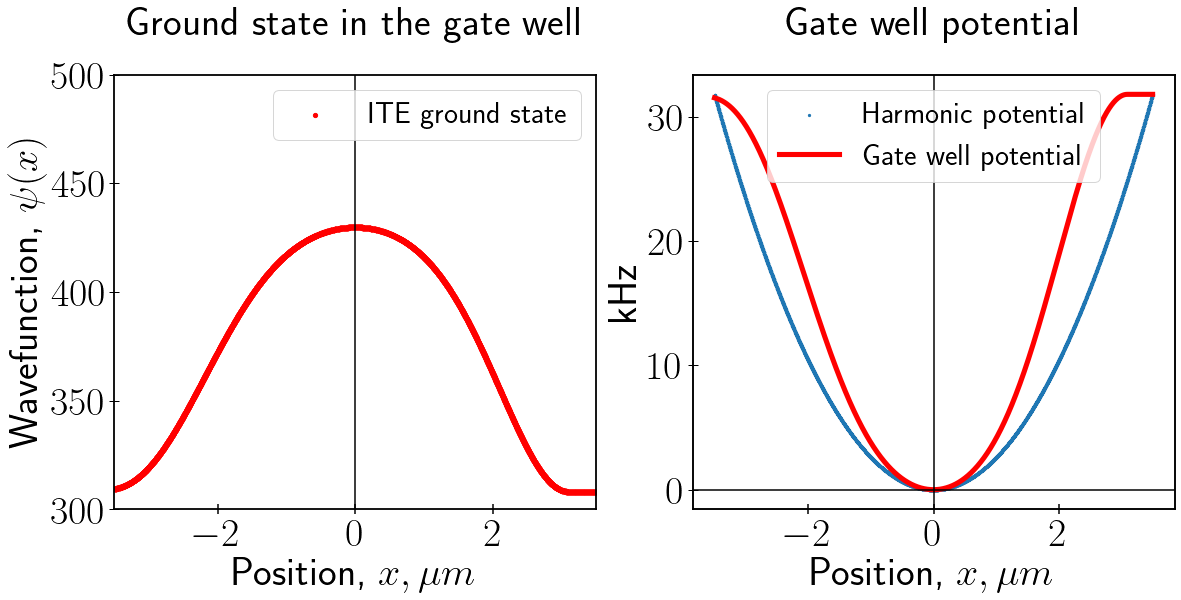

In [58]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
#plt.plot(xs/(1.e-6),normalize_x(psi_0(xs)),label="Exact ground state of QHO",linewidth = 3.1)
plt.scatter(xs/(1.e-6),psi_ITE[0].real,s=18.1,color='red',label="ITE ground state")
plt.xlim([min(xs)/(1.e-6),max(xs)/(1.e-6)])
plt.ylim([300,500])
plt.legend()
plt.title('Exact wavefunction')
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
plt.title('Ground state in the gate well')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.8)
    
plt.subplot(122)
# Plots the gate well potential.
#plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
#plt.ylabel(r"kHz")

# Plots the harmonic oscillator potential.
plt.scatter(xs/(1.e-6),0.5*M*OMEGA**2*(xs)**2/(10**3*2*PI*H_BAR),s = 5,label="Harmonic potential")
plt.plot(extended_gate_well_position,extended_gate_well_potential,color="red",linewidth = 5.1,label="Gate well potential")
plt.legend()
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Gate well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
f.set_figwidth(19)
f.set_figheight(8)
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
plt.show()